## Notebook 8
### Giorgio Stucchi - 969107

In [2]:
# importazione librerie
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
import string
from scipy.optimize import curve_fit
warnings.filterwarnings('ignore')
params = {'legend.fontsize': 'x-large', 'figure.figsize': (10, 6), 'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large', 'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

Objective: Numerically determine the ground state of a quantum system described by a Hamiltonian $H$ with potential $V(x)$ given by:
$$ V(x) = x^4 - \frac{5}{2}x^2 $$

To do this, we use the variational principle with the goal of minimizing the following quantity:
$$\langle {\hat H} \rangle_T = \frac{\int dx \psi^*_T(x) {\hat H} \psi_T(x)}{\int dx |\psi_T(x)|^2} $$

where $\psi_T^{\sigma,\mu}$ is the trial wave function with $\sigma$ and $\mu$ as variational parameters:
$$
\psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

By applying the variational principle, the expectation value of the Hamiltonian $H$ for the trial function will always be greater than or equal to the expectation value for the ground state, given by:
$$
\langle \hat{H}\rangle_T = \frac{\int dx\psi_T^{\mu,\sigma *}(x)\hat{H}\psi_T^{\mu,\sigma }(x)}{\int dx |\psi_T^{\mu,\sigma}(x)|^2}
= \int dx \frac{|\psi_T^{\mu,\sigma}(x)|^2}{\int dx |\psi_T^{\mu,\sigma}(x)|^2} \frac{{\hat H} \psi_T^{\mu,\sigma}(x)}{\psi_T^{\mu,\sigma}(x)} = \int dxp(x)E_{loc}(x)$$

In particular, we observe that the function $p(x)$ is a probability density and can be sampled using the Metropolis algorithm, while $E_{loc}(x)$ is known and directly samplable. Therefore, the integral can be solved using Monte Carlo techniques.

Note: The term "Variational Monte Carlo" refers to the use of Metropolis and Monte Carlo algorithms to compute expectation values.

The objective of the first part of the exercise is to compute the average energy given a trial function ($\mu$ and $\sigma$ fixed). Starting from a position $x$ (where $|\psi(x)|$ is not too small), a displacement $\delta$ is proposed, which is accepted with probability $p(x) = \frac{|\psi(x+\delta)|^2}{|\psi(x)|^2}$.

We then use the code thus produced for a Simulated Annealing algorithm. The problem of finding the ground state (and thus the ground state energy) is an optimization problem. In this case, we need to find the parameters $\sigma$ and $\mu$ that minimize $\langle \hat{H} \rangle_T$. To solve this problem, the simulated annealing (SA) algorithm can be used.

To minimize the energy (or generally the cost function), the system is slowly cooled down. As in statistical physics, we construct the Boltzmann function $$\frac{e^{-\beta H_{\mu,\sigma}}}{Z}$$

Cooling down the system means increasing $\beta$. It is observed that as $\beta$ increases, the Boltzmann distribution concentrates on the minima of $H$ (i.e., the cost function). The simulated annealing is performed in blocks of 50 steps (we perform 50 trial Metropolis moves on $\mu$ and $\sigma$) for 30 temperatures.

Each integral estimate is obtained with metropolis integration. Each estimate that eventually ends up in the calculation of the data blocking is done with 1000 points. The proposed move is a displacement of the parameters of $\Delta_{ann}$ with $\Delta_{ann} = 0.05$ and $\beta_i = \beta_{i-1} + 100$. The parameters are chosen to achieve an acceptance rate of around 50% for most temperatures, that eventually becomes close to zero as beta increases.

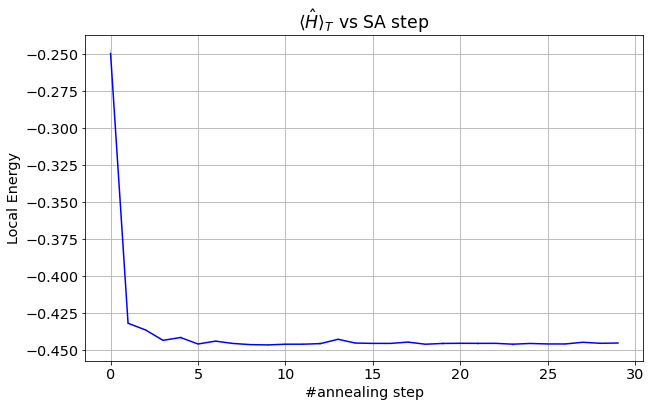

In [3]:
f, error= np.loadtxt("output_energies_annealing.dat",usecols=(0,1), unpack='true')
x = np.arange(len(f))
plt.errorbar(x,f, error, color= 'blue', ecolor ='lightblue')
plt.xlabel('#annealing step')
plt.ylabel('Local Energy')
plt.title(r'$\langle {\hat H} \rangle_T$ vs SA step')
plt.grid(True)
plt.show()

We now show the path of the parameters in the parameters space. Color represents the step (better said, the temperature of the step).

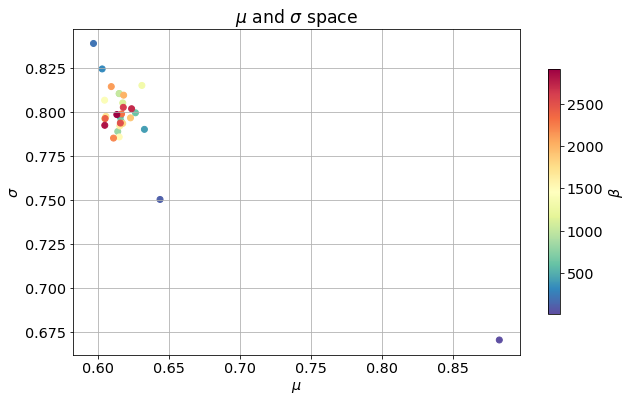

In [4]:
cycle = 30
betamin = 10.
beta = np.arange(betamin, betamin + cycle * 100., 100)
sigmas, mus = np.loadtxt("output_mus_sigmas.dat",usecols=(0,1), unpack='true')
plt.scatter(sigmas,mus,c=beta,cmap="Spectral_r")
plt.colorbar(label="$\\beta$",orientation="vertical",shrink=0.75)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("$\mu$ and $\sigma$ space")
plt.grid(True)

What follows is a picture of the estimation of $\langle {\hat H} \rangle_T$ </span> and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$.

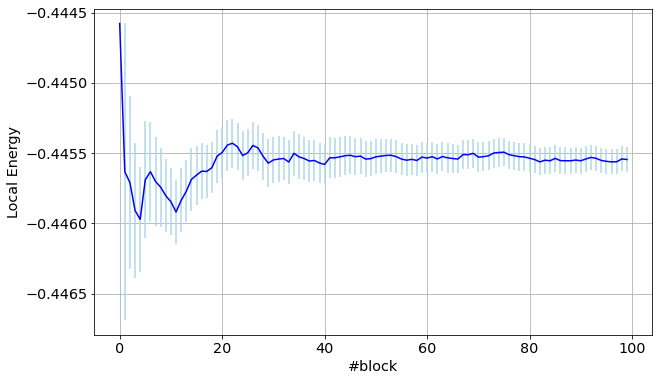

In [5]:
f, error= np.loadtxt("output_int.dat",usecols=(2,3), unpack='true')
x = np.arange(len(f))
plt.errorbar(x,f, error, color= 'blue', ecolor ='lightblue')
plt.xlabel('#block')
plt.ylabel('Local Energy')
plt.grid(True)
plt.show()
#done with values of sigma and mu that minimize the energy (0.613401 and 0.798773)

Finally, we compare the sampled $|\Psi_T(x)|^2$ with the analytic curve of $|\Psi_T(x)|^2$ and the ground state solution with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

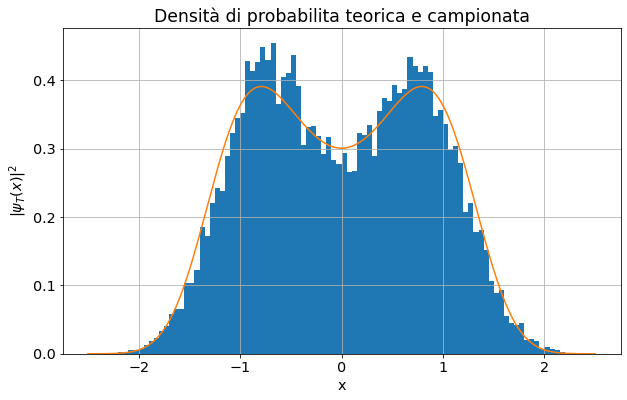

In [6]:
data = np.loadtxt("histo.dat", usecols=(0), delimiter=None, unpack='true')

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/4, a/4, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

plt.hist(data, 100, density = True, range = (-a/4,a/4) )
plt.plot(x, psi[0]**2)
plt.title("Densità di probabilita teorica e campionata")
plt.xlabel("x")
plt.ylabel("$|\psi_T(x)|^2$")
plt.grid()
plt.show()

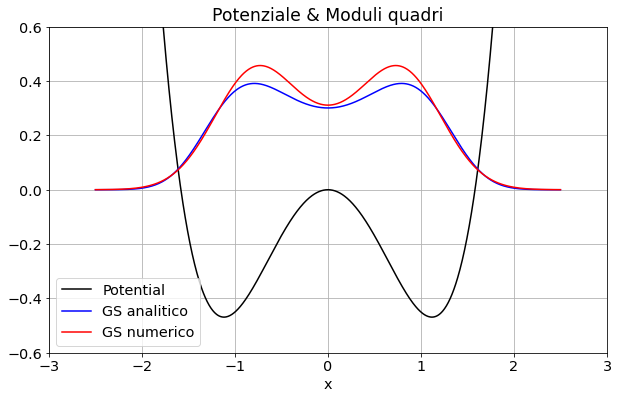

In [7]:
#plot soluzione numerica - NB: mu e sigma sono all'incirca quelli che abbiamo trovato minimizzando
mu = 0.798
sigma = 0.613
gau = 1/(sigma*np.sqrt(2*np.pi)) * (np.exp(-(x-mu)**2/(2*sigma**2)) + np.exp(-(x+mu)**2/(2*sigma**2)))

# Plot a few things
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2, color="Blue", label="GS analitico") #plot GS analitico
plt.plot(x,(gau**2), color="Red", label="GS numerico")#plot GS numerico
#soluzione con simulated Annealing
plt.title("Potenziale & Moduli quadri")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.legend()
plt.show()

The computed GS doesn't coincide with the analytical one, but this is not surprising. MC simulated annealing aim for a solution close to the exact one (particularly in terms of energy), not the exact one.